In [1]:
using CSV, DataFrames, ColorTypes, JuMP, HiGHS, Plots, Interpolations

# Data Import

In [3]:
function load_data(file_path::String, location::Int, period::Int)
    data = CSV.read(file_path, DataFrame)

    filtered_data = data[(data.Location .== location) .& (data.Period .== period), :]
    filtered_data.ID = collect(1:nrow(filtered_data))
    return filtered_data
end

load_data (generic function with 1 method)

# Calculations

## Single Market

In [6]:
function create_market_model(data::DataFrame)
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, 0 <= x[data.ID] <= 1)

    @objective(model, Max, sum(data[i, "Price"] * data[i, "Quantity"] * x[i] for i in data.ID))

    @constraint(model, balance, sum(data[i, "Quantity"] * x[i] for i in data.ID) == 0)

    return model, x, balance
end


create_market_model (generic function with 1 method)

In [7]:
function optimize_and_compute_results(model, data::DataFrame, x, balance)
    optimize!(model)

    price = (-1) * dual(balance)

    demand = data[data.Quantity .>= 0, :]
    supply = data[data.Quantity .< 0, :]

    demand.Acceptance_Ratio = [value(x[i]) for i in demand.ID]
    supply.Acceptance_Ratio = [value(x[i]) for i in supply.ID]

    cleared_volume = sum(abs(supply[i, "Quantity"]) * value(x[supply.ID[i]]) for i in eachindex(supply.ID))

    demand_sorted = sort(demand, :Price, rev=true)
    cumulative_demand = cumsum(demand_sorted.Quantity)
    
    supply_sorted = sort(supply, :Price)
    cumulative_supply = cumsum(supply_sorted.Quantity)
    
    if any(cleared_volume .== cumulative_demand)
    
        i = 1
        
        while i <= length(cumulative_supply) && cumulative_supply[i] > -cleared_volume
            
            i += 1
        end

        price = supply_sorted[i-1, "Price"]
    end

    consumer_surplus = sum((demand[i, "Price"] - price) * demand[i, "Quantity"] * demand[i, "Acceptance_Ratio"] for i in eachindex(demand.ID))

    producer_surplus = sum((price - supply[i, "Price"]) * abs(supply[i, "Quantity"]) * supply[i, "Acceptance_Ratio"] for i in eachindex(supply.ID))

    welfare = consumer_surplus + producer_surplus

    return price, consumer_surplus, producer_surplus, cleared_volume, welfare
end

optimize_and_compute_results (generic function with 1 method)

## Connected Market

In [ ]:
function t(data_m1::DataFrame, data_m2::DataFrame, trade_capacity::Int)
    model = Model(HiGHS.Optimizer)
    set_silent(model)

    @variable(model, 0 <= x_m1[data_m1.ID] <= 1)
    @variable(model, 0 <= x_m2[data_m2.ID] <= 1)
    
    @variable(model, -trade_capacity <= trade <= trade_capacity)

    @objective(model, Max, 
        sum(data_m1[i, "Price"] * data_m1[i, "Quantity"] * x_m1[i] for i in data_m1.ID) +
        sum(data_m2[i, "Price"] * data_m2[i, "Quantity"] * x_m2[i] for i in data_m2.ID)
    )

    @constraint(model, balance_m1, sum(data_m1[i, "Quantity"] * x_m1[i] for i in data_m1.ID) + trade == 0)
    @constraint(model, balance_m2, sum(data_m2[i, "Quantity"] * x_m2[i] for i in data_m2.ID) - trade == 0)

    return model, x_m1, x_m2, balance_m1, balance_m2, trade
end

create_trade_market_model (generic function with 1 method)

In [10]:
function optimize_and_compute_trade_results(model, data_m1::DataFrame, data_m2::DataFrame, x_m1, x_m2, balance_m1, balance_m2, trade, trade_capacity)
    optimize!(model)

    price_m1 = (-1) * dual(balance_m1)
    price_m2 = (-1) * dual(balance_m2)

    demand_m1 = data_m1[data_m1.Quantity .>= 0, :]
    supply_m1 = data_m1[data_m1.Quantity .< 0, :]

    demand_m1.Acceptance_Ratio = [value(x_m1[i]) for i in demand_m1.ID]
    supply_m1.Acceptance_Ratio = [value(x_m1[i]) for i in supply_m1.ID]
    
    cleared_volume_m1 = sum(abs(supply_m1[i, "Quantity"]) * value(x_m1[supply_m1.ID[i]]) for i in eachindex(supply_m1.ID))

    demand_m1_sorted = sort(demand_m1, :Price, rev=true)
    cumulative_demand_m1 = cumsum(demand_m1_sorted.Quantity)

    supply_m1_sorted = sort(supply_m1, :Price)
    cumulative_supply_m1 = cumsum(supply_m1_sorted.Quantity)
    
    if any(cleared_volume_m1+trade_capacity .== cumulative_demand_m1)
    
        i = 1
        
        while i <= length(cumulative_supply_m1) && cumulative_supply_m1[i] > -cleared_volume_m1
            
            i += 1
        end

        price_m1 = supply_m1_sorted[i-1, "Price"]
    end
    
    demand_m2 = data_m2[data_m2.Quantity .>= 0, :]
    supply_m2 = data_m2[data_m2.Quantity .< 0, :]

    demand_m2.Acceptance_Ratio = [value(x_m2[i]) for i in demand_m2.ID]
    supply_m2.Acceptance_Ratio = [value(x_m2[i]) for i in supply_m2.ID]
    
    cleared_volume_m2 = sum(abs(supply_m2[i, "Quantity"]) * value(x_m2[supply_m2.ID[i]]) for i in eachindex(supply_m2.ID))
    
    demand_m2_sorted = sort(demand_m2, :Price, rev=true)
    cumulative_demand_m2 = cumsum(demand_m2_sorted.Quantity)

    supply_m2_sorted = sort(supply_m2, :Price)
    cumulative_supply_m2 = cumsum(supply_m2_sorted.Quantity)
    
    
    if any(cleared_volume_m2+trade_capacity .== cumulative_demand_m2)

        i = 1
        
        while i <= length(cumulative_supply_m2) && cumulative_supply_m2[i] > -cleared_volume_m2
            
            i += 1
        end
        price_m2 = supply_m2_sorted[i-1, "Price"]
    end
    
    consumer_surplus_m2 = sum((demand_m2[i, "Price"] - price_m2) * demand_m2[i, "Quantity"] * demand_m2[i, "Acceptance_Ratio"] for i in eachindex(demand_m2.ID))
    producer_surplus_m2 = sum((price_m2 - supply_m2[i, "Price"]) * abs(supply_m2[i, "Quantity"]) * supply_m2[i, "Acceptance_Ratio"] for i in eachindex(supply_m2.ID))

    consumer_surplus_m1 = sum((demand_m1[i, "Price"] - price_m1) * demand_m1[i, "Quantity"] * demand_m1[i, "Acceptance_Ratio"] for i in eachindex(demand_m1.ID))
    producer_surplus_m1 = sum((price_m1 - supply_m1[i, "Price"]) * abs(supply_m1[i, "Quantity"]) * supply_m1[i, "Acceptance_Ratio"] for i in eachindex(supply_m1.ID))
    
    welfare = consumer_surplus_m1 + producer_surplus_m1 + consumer_surplus_m2 + producer_surplus_m2

    traded_volume = value(trade)
    
    congestion_rate = abs(traded_volume) / trade_capacity

    return price_m1, price_m2, consumer_surplus_m1, producer_surplus_m1, consumer_surplus_m2, producer_surplus_m2, cleared_volume_m1, cleared_volume_m2, traded_volume, welfare, congestion_rate
end

optimize_and_compute_trade_results (generic function with 1 method)

# Main / Results

## Single Market

In [13]:
file_path = "00_src/hourly_orders.csv"

#println("Import successful\n")

data_m1 = load_data(file_path, 11, 24)
data_m2 = load_data(file_path, 12, 24)

#println("Data market 1 load successful\n")

model_m1, x_m1, balance_m1 = create_market_model(data_m1)
model_m2, x_m2, balance_m2 = create_market_model(data_m2)

#println("Model market 1 creation successful\n")

price_m1, cs_m1, ps_m1, cleared_volume_m1, welfare_m1 = optimize_and_compute_results(model_m1, data_m1, x_m1, balance_m1)
price_m2, cs_m2, ps_m2, cleared_volume_m2, welfare_m2 = optimize_and_compute_results(model_m2, data_m2, x_m2, balance_m2)

println("\nMarket 1\nPrice: ", price_m1, "\nClearedVol: ", cleared_volume_m1, "\nCS: ", cs_m1, "\nPS: ", ps_m1, "\nWelfare: ", welfare_m1)
println("\nMarket 2\nPrice: ", price_m2, "\nClearedVol: ", cleared_volume_m2, "\nCS: ", cs_m2, "\nPS: ", ps_m2, "\nWelfare: ", welfare_m2)


Market 1
Price: 21.23
ClearedVol: 30163.9
CS: 4.506929052000002e6
PS: 606236.7360000003
Welfare: 5.1131657880000025e6

Market 2
Price: 125.56
ClearedVol: 6892.0
CS: 377268.0800000001
PS: 799422.411
Welfare: 1.176690491e6


## Connected Markets

In [15]:
trade_capacity = 400

model, x_m1, x_m2, balance_m1, balance_m2, trade = create_trade_market_model(data_m1, data_m2, trade_capacity)

trade_price_m1, trade_price_m2, trade_cs_m1, trade_ps_m1, trade_cs_m2, trade_ps_m2, trade_cleared_volume_m1, trade_cleared_volume_m2, traded_volume, trade_welfare, congestion_rate = optimize_and_compute_trade_results(model, data_m1, data_m2, x_m1, x_m2, balance_m1, balance_m2, trade, trade_capacity)

println("\nMarket 1\nPrice: ", trade_price_m1, "\nClearedVol: ", trade_cleared_volume_m1, "\nCS: ", trade_cs_m1, "\nPS: ", trade_ps_m1, "\nWelfare: ", trade_cs_m1+trade_ps_m1)
println("\nMarket 2\nPrice: ", trade_price_m2, "\nClearedVol: ", trade_cleared_volume_m2, "\nCS: ", trade_cs_m2, "\nPS: ", trade_ps_m2, "\nWelfare: ", trade_cs_m2+trade_ps_m2)
println("\nTrading\nTradedVol: ", traded_volume, "\nWelfare total: ", trade_welfare, "\ncongestion rate: ", congestion_rate)


Market 1
Price: 24.8
ClearedVol: 30550.8
CS: 4.399290696000002e6
PS: 714524.389
Welfare: 5.113815085000003e6

Market 2
Price: 100.0
ClearedVol: 6498.3
CS: 553437.6000000001
PS: 635056.3499999999
Welfare: 1.18849395e6

Trading
TradedVol: 400.0
Welfare total: 6.302309035000002e6
congestion rate: 1.0


# Plotting

In [17]:
#println(data_m1)
#println(sum(abs.(data_m1.Quantity)))

In [18]:
using DataFrames, Plots

function plot_supply_demand(df::DataFrame, price_eq::Float64, quantity_eq::Float64)
    demand_df = filter(row -> row.Quantity > 0, df)  
    supply_df = filter(row -> row.Quantity < 0, df)  

    sort!(supply_df, :Price)
    sort!(demand_df, :Price, rev=true) 

    supply_df.Quantity = cumsum(abs.(supply_df.Quantity))  
    demand_df.Quantity = cumsum(demand_df.Quantity)  

    pushfirst!(supply_df, (ID=0, Price=0.0, Quantity=0.0, Location=0, Period=0)) 
    pushfirst!(demand_df, (ID=0, Price=maximum(df.Price), Quantity=0.0, Location=0, Period=0)) 

    plt = plot(supply_df.Quantity, supply_df.Price, label="Supply", lw=2, color=:red, seriestype=:steppost)
    plot!(plt, demand_df.Quantity, demand_df.Price, label="Demand", lw=2, color=:blue, seriestype=:steppost)

    hline!([price_eq], lw=1, linestyle=:dash, color=:black, label="")
    vline!([quantity_eq], lw=1, linestyle=:dash, color=:black, label="")
    
    plot!([quantity_eq], [price_eq], seriestype=:scatter, label="Equilibrium", lw=0, color=:green, markersize=6)

    konsumentenrente_gezeichnet = false
    for i in 1:length(demand_df.Quantity) - 1
        if demand_df.Quantity[i] <= quantity_eq
            x_fill = [demand_df.Quantity[i], demand_df.Quantity[i+1], demand_df.Quantity[i+1], demand_df.Quantity[i]]
            y_fill = [demand_df.Price[i], demand_df.Price[i], price_eq, price_eq]
            if !konsumentenrente_gezeichnet
                plot!(x_fill, y_fill, seriestype=:shape, lw=0, color=:blue, alpha=0.3, label="ConSP")
                konsumentenrente_gezeichnet = true
            else
                plot!(x_fill, y_fill, seriestype=:shape, lw=0, color=:blue, alpha=0.3, label="")
            end
        end
    end

    produzentenrente_gezeichnet = false
    for i in 1:length(supply_df.Quantity) - 1
        if supply_df.Quantity[i] <= quantity_eq
            x_fill = [supply_df.Quantity[i], supply_df.Quantity[i+1], supply_df.Quantity[i+1], supply_df.Quantity[i]]
            y_fill = [supply_df.Price[i], supply_df.Price[i], price_eq, price_eq]
            if !produzentenrente_gezeichnet
                plot!(x_fill, y_fill, seriestype=:shape, lw=0, color=:orange, alpha=0.3, label="ProdSP")
                produzentenrente_gezeichnet = true
            else
                plot!(x_fill, y_fill, seriestype=:shape, lw=0, color=:orange, alpha=0.3, label="")
            end
        end
    end

    xlabel!(plt, "Quantity", guidefont=font(10))  
    ylabel!(plt, "Price", guidefont=font(10))  

    return plt
end

plot_supply_demand (generic function with 1 method)

Equi at: 21.23 and 30163.9


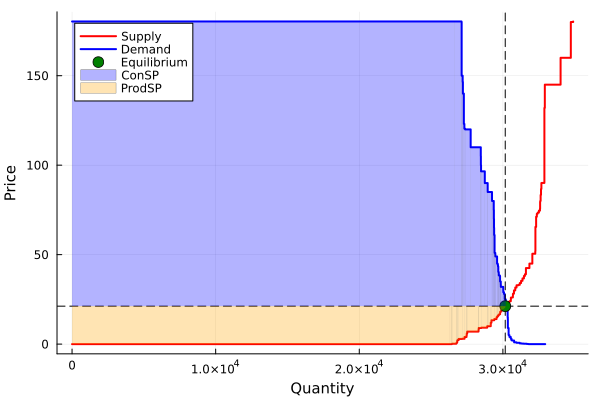

In [19]:
println("Equi at: ", price_m1, " and ", cleared_volume_m1)

#savefig(plot_supply_demand(data_m1, price_m1, cleared_volume_m1), "market1plot.png")
plot_supply_demand(data_m1, price_m1, cleared_volume_m1)

Equi at: 125.56 and 6892.0


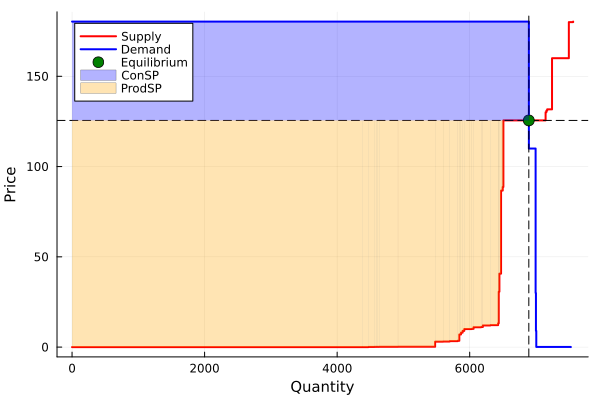

In [20]:
println("Equi at: ", price_m2, " and ", cleared_volume_m2)

#savefig(plot_supply_demand(data_m2, price_m2, cleared_volume_m2), "market2plot.png")
plot_supply_demand(data_m2, price_m2, cleared_volume_m2)